In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.signal import detrend, correlation_lags
from statsmodels.tsa.stattools import adfuller
import seaborn as sns
import sys
import os

%matplotlib inline

class TopPostsSelector(object):
    def __init__(self, df_posts, df_comments, cutoff_posts=0.9, cutoff_comments=0.8):
        self.posts = df_posts
        self.comments = df_comments

        self.cutoff_posts = cutoff_posts
        self.cutoff_comments = cutoff_comments

    def parser(self):
        posts = self.posts
        comments = self.comments

        posts['timestamp'] = pd.to_datetime(posts['timestamp']).dt.tz_localize('Etc/GMT+8')\
            .dt.tz_convert('America/New_York')
        posts['score'] = pd.to_numeric(posts['score'])
        posts['date'] = pd.to_datetime(posts['timestamp'].dt.strftime('%Y-%m-%d'))
        # posts['minute'] = np.where(posts['timestamp'].dt.minute< 30, '00', '30')
        # posts['date'] = pd.to_datetime(posts['date'].dt.strftime('%Y-%m-%dT%H') + ':' + posts['minute'])
        posts = posts[posts['date'] >= '2021-01-29']

        comments['score'] = pd.to_numeric(comments['score'])

        top_posts = posts.groupby(['date']) \
            .apply(lambda g: g[g['score'] >= np.quantile(g['score'], self.cutoff_posts)]) \
            .reset_index(drop=True)

        top_comments = comments[comments['id_col'].isin(top_posts['id'])] \
            .groupby('id_col')\
            .apply(lambda g: g[g['score'] >= np.quantile(g['score'], self.cutoff_comments)]) \
            .reset_index(drop=True)

        return top_posts, top_comments

def sentiment_counts(df, relative=False):
    sent_date = df.groupby(['date', 'sent_label']).size().to_frame('size').reset_index()\
        .pivot(index='date', columns='sent_label', values='size').reset_index().fillna('0')
    sent_date[['negative', 'positive']] = sent_date[['negative', 'positive']].astype('int32')

    sent_date['date'] = sent_date['date'].dt.tz_localize('America/New_York')
    if relative is True:
        sent_date['tot'] = sent_date['negative'] + sent_date['positive']
        sent_date['negative'] = sent_date['negative'] / sent_date['tot']
        sent_date['positive'] = sent_date['positive'] / sent_date['tot']

    return sent_date

def sentiment_counts_plt(df, ax=None, relative=False, count_data=False):
    if not count_data:
        df = sentiment_counts(df, relative)

    if ax is None:
        ax = plt.gca()

    for col in ['negative', 'positive']:
        ax.plot(df['date'], df[col], label=col)

    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))

    for label in ax.get_xticklabels(which='major'):
        label.set(rotation=30, horizontalalignment='right')

    return ax


In [4]:
df_posts = pd.read_csv('../data/senti_posts.zip').drop(6161)
df_comments = pd.read_csv('../data/senti_comments.zip', lineterminator='\n')

top_posts, top_comments = TopPostsSelector(df_posts, df_comments, cutoff_posts=0.8, cutoff_comments=0.75).parser()

top_comments = top_comments.merge(top_posts[['id', 'date']], left_on='id_col', right_on='id') \
    .drop('id', axis=1)

In [3]:
print(f'{top_posts.shape[0] / df_posts.shape[0]:.2%}, {top_comments.shape[0] / df_comments.shape[0]:.2%}')

20.69%, 16.97%


In [6]:
top_posts

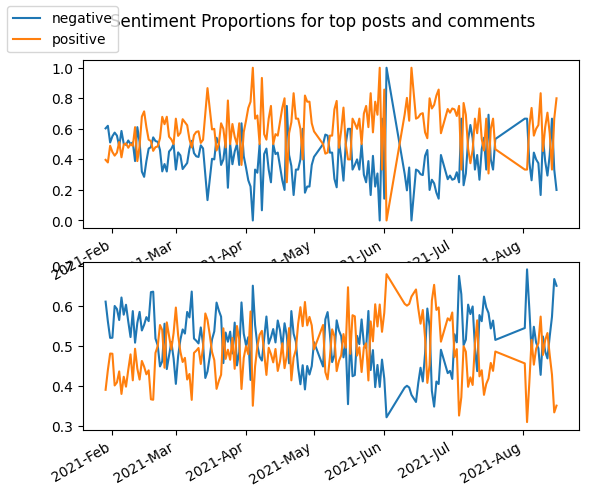

In [5]:
fig, ax = plt.subplots(2, 1)
sentiment_counts_plt(top_posts, ax[0], relative=True)
sentiment_counts_plt(top_comments, ax[1], relative=True)
handles, labels = fig.gca().get_legend_handles_labels()
dict_of_labels = dict(zip(labels, handles))
fig.legend(dict_of_labels.values(), dict_of_labels.keys(), loc='upper left')
fig.suptitle('Sentiment Proportions for top posts and comments');

In [31]:
posts_count = sentiment_counts(top_posts, relative=True)
comments_count = sentiment_counts(top_comments, relative=True)

def linear_detrend(df):
    p_val = {}
    for count in df.drop(['date', 'tot'], axis=1).columns:
        df[count] = detrend(df[count], type='linear')
        p = adfuller(df[count], autolag='AIC')[1]
        p_val[count] = p

    return df, p_val

posts_count, p_posts = linear_detrend(posts_count)
comments_count, p_comments = linear_detrend(comments_count)

In [6]:
p_comments, p_posts

({'negative': 7.191430383971672e-06, 'positive': 7.1914303839713775e-06},
 {'negative': 5.920262183152326e-22, 'positive': 5.920262183152326e-22})

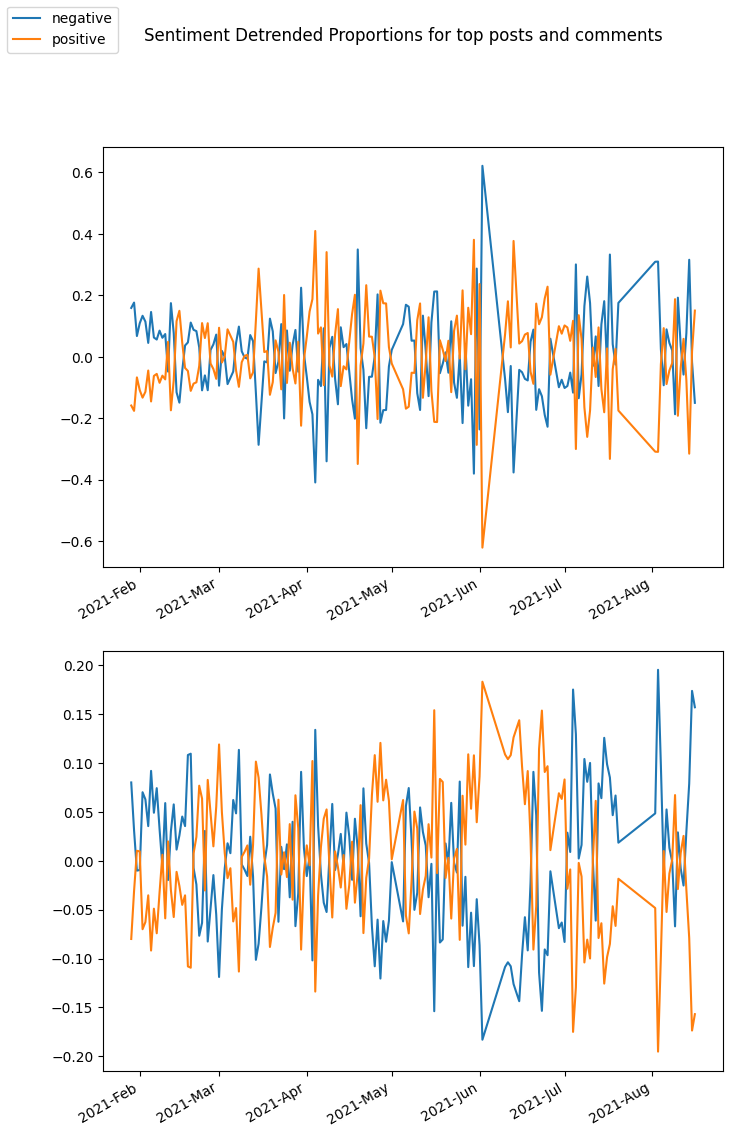

In [7]:
fig, ax = plt.subplots(2, 1, figsize = (8,12))
sentiment_counts_plt(posts_count, ax[0], count_data=True)
sentiment_counts_plt(comments_count, ax[1], count_data=True)
handles, labels = fig.gca().get_legend_handles_labels()
dict_of_labels = dict(zip(labels, handles))
fig.legend(dict_of_labels.values(), dict_of_labels.keys(), loc='upper left')
fig.suptitle('Sentiment Detrended Proportions for top posts and comments');

In [11]:
posts_count

sent_label,date,negative,positive,tot
0,2021-01-29 00:00:00,-0.071277,0.071277,5
1,2021-01-29 00:30:00,0.528747,-0.528747,1
2,2021-01-29 02:30:00,0.260829,-0.260829,209
3,2021-01-29 04:00:00,0.060494,-0.060494,978
4,2021-01-29 04:30:00,0.197886,-0.197886,556
...,...,...,...,...
6120,2021-08-16 10:30:00,-0.320907,0.320907,1
6121,2021-08-16 11:00:00,-0.320882,0.320882,1
6122,2021-08-16 11:30:00,0.179143,-0.179143,2
6123,2021-08-16 12:30:00,0.679167,-0.679167,1


In [41]:
posts_count.info()

sent_label,date,negative,positive,tot
0,2021-01-29 00:00:00,0.042120,-0.042120,17
1,2021-01-29 00:30:00,0.512734,-0.512734,3
2,2021-01-29 02:30:00,0.144283,-0.144283,939
3,2021-01-29 04:00:00,0.034045,-0.034045,4798
4,2021-01-29 04:30:00,0.178663,-0.178663,2451
...,...,...,...,...
6120,2021-08-16 10:30:00,0.171697,-0.171697,2
6121,2021-08-16 11:00:00,-0.328277,0.328277,1
6122,2021-08-16 11:30:00,0.171749,-0.171749,2
6123,2021-08-16 12:30:00,0.671775,-0.671775,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6125 entries, 0 to 6124
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      6125 non-null   datetime64[ns]
 1   negative  6125 non-null   float64       
 2   positive  6125 non-null   float64       
 3   tot       6125 non-null   int32         
dtypes: datetime64[ns](1), float64(2), int32(1)
memory usage: 167.6 KB


In [9]:
df_amc = pd.read_csv('../stocks/AMC.csv')
df_amc = df_amc.rename(columns={'Date': 'date'})
df_amc['date'] = pd.to_datetime(df_amc['date']).dt.tz_localize('Europe/Berlin')\
            .dt.tz_convert('America/New_York')

df_amc['hour'] = df_amc['date'].dt.hour
df_amc['date'] = df_amc['date'].dt.strftime('%Y-%m-%d')
df_amc = df_amc.groupby('date').apply(lambda g: g[g['hour'] == np.max(g['hour'])]).reset_index(drop=True)
df_amc.groupby(['date', 'hour']).size().reset_index()['hour'].unique()

array([15], dtype=int32)

In [10]:
class StockPipeLine(object):
    def __init__(self, df, only_last_call):
        self.df = df
        self.only_last_call = only_last_call

    def parser(self):
        df = self.df
        df = df.rename(columns={'Date': 'date'})
        df['date'] = pd.to_datetime(df['date']).dt.tz_localize('Europe/Berlin')\
            .dt.tz_convert('America/New_York')
        if self.only_last_call:
            df['hour'] = df['date'].dt.hour
            df['date'] = df['date'].dt.strftime('%Y-%m-%d')
            df = df.groupby('date')\
                    .apply(lambda g: g[g['hour'] == np.max(g['hour'])]) \
                    .reset_index(drop=True)
            df = df.drop('hour', axis=1)

        df['Last Price'] = pd.to_numeric(df['Last Price'].str.replace(',', '.'))

        df['close_lag'] = df['Last Price'].shift(1, axis = 0)
        df.loc[0,'close_lag'] = df.loc[1,'close_lag']
        df['first_diff'] = df['close_lag'] - df['Last Price']

        df['close_returns'] = (df['Last Price'] - df['close_lag'])/df['close_lag']
        df.loc[0,'close_returns'] = df['close_returns'].median()
        df = df.drop('close_lag', axis=1)

        return df


In [29]:
df_amc = pd.read_csv('../stocks/AMC.csv')
df_gme = pd.read_csv('../stocks/GME.csv')
df_amc = StockPipeLine(df_amc, only_last_call=True).parser()
df_gme = StockPipeLine(df_gme, only_last_call=True).parser()

In [32]:
# df_amc['date'] = df_amc['date'].dt.strftime('%Y-%m-%d')
comments_count['date'] = comments_count['date'].dt.strftime('%Y-%m-%d')

In [14]:
comments_count

sent_label,date,negative,positive,tot
0,2021-01-29,0.080031,-0.080031,18005
1,2021-01-30,0.030874,-0.030874,11967
2,2021-01-31,-0.010132,0.010132,9529
3,2021-02-01,-0.009483,0.009483,7373
4,2021-02-02,0.070047,-0.070047,4420
...,...,...,...,...
170,2021-08-12,-0.025365,0.025365,489
171,2021-08-13,0.029893,-0.029893,514
172,2021-08-14,0.079015,-0.079015,519
173,2021-08-15,0.173642,-0.173642,51


In [33]:
df_sent_stock = comments_count.merge(df_amc[['date', 'close_returns']], on='date', how='left')
df_sent_stock = df_sent_stock[df_sent_stock['close_returns'].notnull()]

In [34]:
df_sent_stock.info()

<class 'pandas.core.frame.DataFrame'>
Index: 196 entries, 0 to 238
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           196 non-null    object 
 1   negative       196 non-null    float64
 2   positive       196 non-null    float64
 3   tot            196 non-null    int32  
 4   close_returns  196 non-null    float64
dtypes: float64(3), int32(1), object(1)
memory usage: 8.4+ KB


In [35]:
def ccf_values(series1, series2):
    p = series1
    q = series2
    p = (p - np.mean(p)) / (np.std(p) * len(p))
    q = (q - np.mean(q)) / (np.std(q))
    c = np.correlate(p, q, 'full')
    return c

ccf_amc = ccf_values(df_sent_stock['positive'], df_sent_stock['close_returns'])

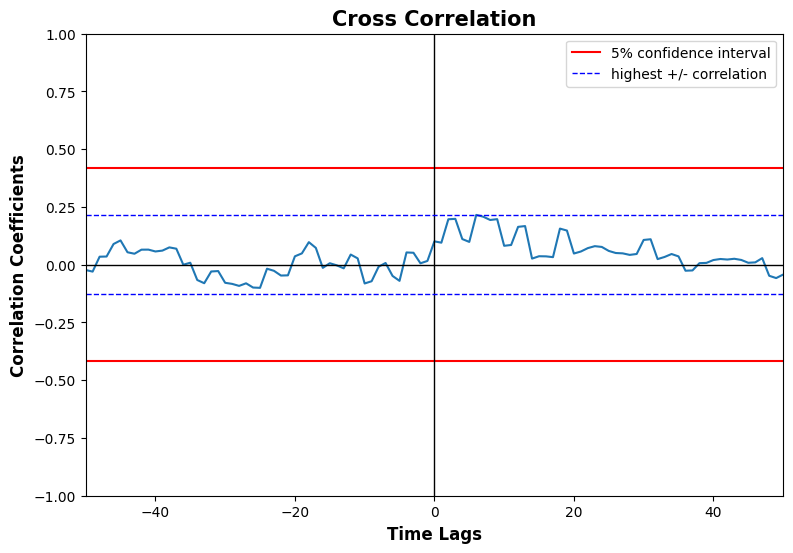

In [36]:
lags = correlation_lags(len(df_sent_stock['positive']), len(df_sent_stock['close_returns']))

def ccf_plot(lags, ccf):
    fig, ax = plt.subplots(figsize=(9, 6))
    ax.plot(lags, ccf)
    ax.axhline(-2/np.sqrt(23), color='red', label='5% confidence interval')
    ax.axhline(2/np.sqrt(23), color='red')
    ax.axvline(x = 0, color = 'black', lw = 1)
    ax.axhline(y = 0, color = 'black', lw = 1)
    ax.axhline(y = np.max(ccf), color = 'blue', lw = 1,
               linestyle='--', label = 'highest +/- correlation')
    ax.axhline(y = np.min(ccf), color = 'blue', lw = 1,
               linestyle='--')
    ax.set(ylim = [-1, 1], xlim=[-50,50])
    ax.set_title('Cross Correlation', weight='bold', fontsize = 15)
    ax.set_ylabel('Correlation Coefficients', weight='bold',
                  fontsize = 12)
    ax.set_xlabel('Time Lags', weight='bold', fontsize = 12)
    plt.legend()

ccf_plot(lags, ccf_amc)

In [37]:
df_sent_stock = comments_count.merge(df_gme[['date', 'close_returns']], on='date', how='left')
df_sent_stock = df_sent_stock[df_sent_stock['close_returns'].notnull()]

In [38]:
df_sent_stock.info()

<class 'pandas.core.frame.DataFrame'>
Index: 194 entries, 3 to 237
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           194 non-null    object 
 1   negative       194 non-null    float64
 2   positive       194 non-null    float64
 3   tot            194 non-null    int32  
 4   close_returns  194 non-null    float64
dtypes: float64(3), int32(1), object(1)
memory usage: 8.3+ KB


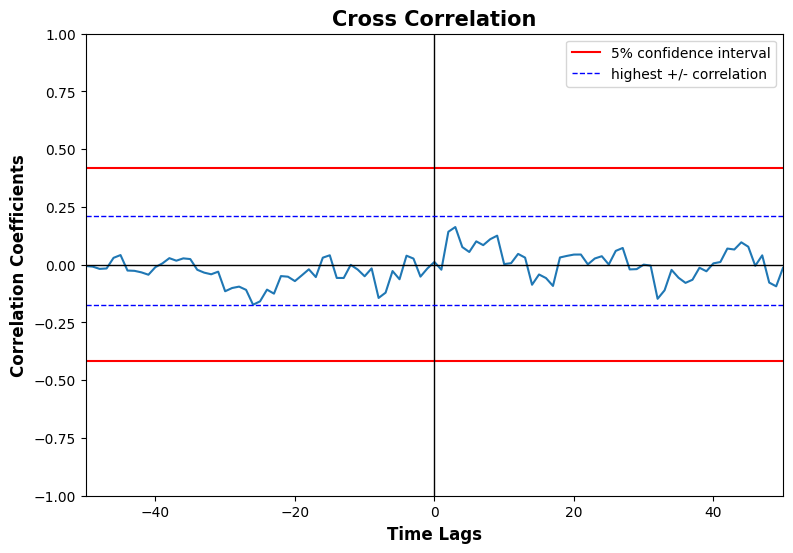

In [42]:
ccf_gme = ccf_values(df_sent_stock['positive'], df_sent_stock['close_returns'])
lags = correlation_lags(len(df_sent_stock['positive']), len(df_sent_stock['close_returns']))

ccf_plot(lags, ccf_gme)

In [41]:
len(lags), len(ccf:)

387